In [1]:
%load_ext autoreload
%autoreload 2

import cv2
from matplotlib import pyplot as plt
import numpy as np
import scipy.linalg

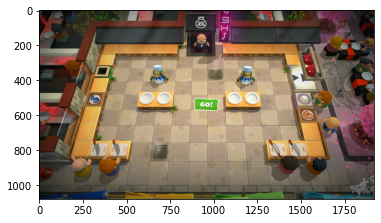

In [2]:
# Load image and interactive view to identify keypoints

img_path = "./overcooked.png"
img_frame = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_RGB2BGR)

# Press any key to close pop-up
cv2.imshow("image", cv2.cvtColor(img_frame, cv2.COLOR_RGB2BGR))
cv2.waitKey(0)
cv2.destroyAllWindows()

plt.imshow(img_frame)

line_inf_homo after applying H_shear^-T: [0. 0. 1.]
pts = [[   0 1920 1920    0]
 [   0    0 1080 1080]]
pts_sheared = [[   0 1924 1154    0]
 [   0    0  649  648]]
pts_target = [[   0 1920 1151    0]
 [   0    0  647  646]]


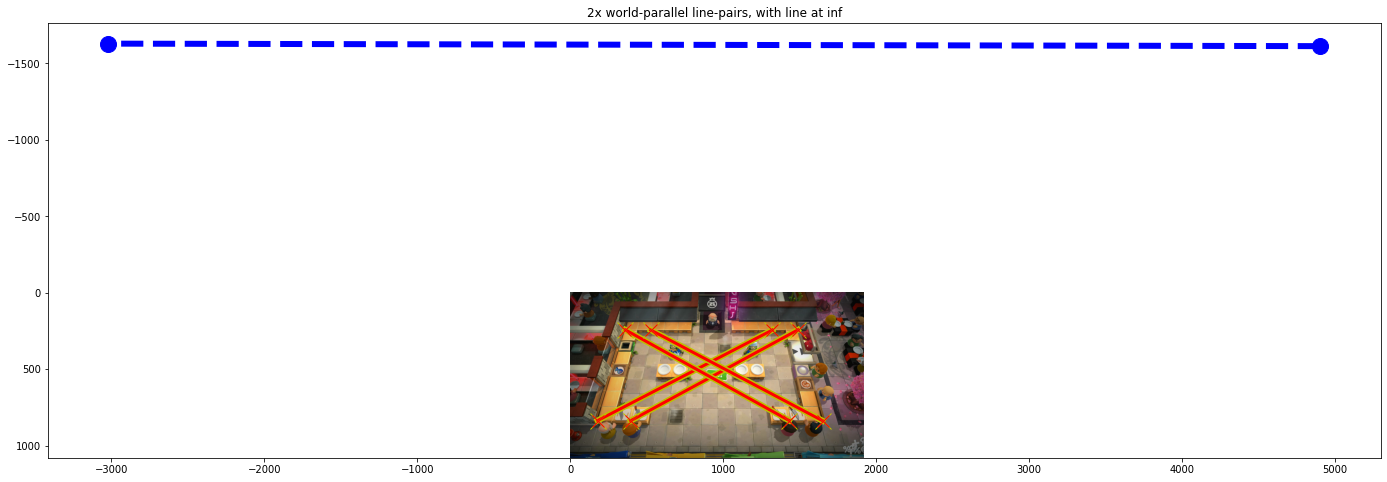

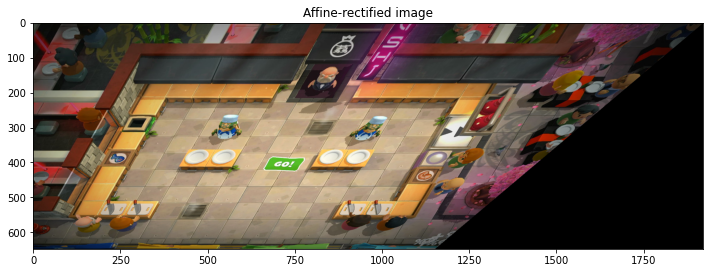

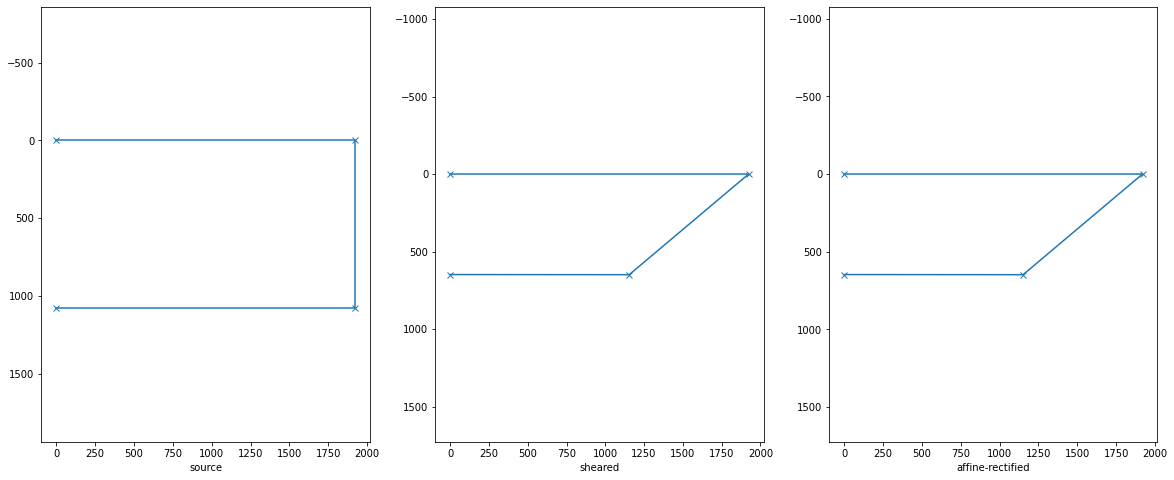

In [3]:
## Example 2.18: Affine rectification (using 2x world-parallel line-pairs to obtain l_inf)

# 0. Specify 2x of world-parallel line-pairs
# Representation: x1, y1, x2, y2
lines_xy = (
    (179, 836, 1321, 244),
    (395, 837, 1488, 243),
    (1431, 836, 360, 243),
    (1649, 837, 526, 244),

    # BEWARE: avoid using 4 world-colinear lines, as below,
    #         since their pt_inf will be too close to accurately solve line_inf
    # (178, 837, 361, 244),
    # (395, 836, 526, 247),
    # (1431, 830, 1322, 246),
    # (1650, 837, 1489, 243),
)

# 1. Transform into homogeneous coordinates
lines_homo = np.array(lines_xy)
x1s, y1s, x2s, y2s = lines_homo[:, 0], lines_homo[:, 1], lines_homo[:, 2], lines_homo[:, 3]
lines_homo = np.array((y1s - y2s, x2s - x1s, x1s * y2s - x2s * y1s))  # 3x4
lines_homo = lines_homo / np.expand_dims(lines_homo[2, :], axis=0)

# np.set_printoptions(formatter={'float': lambda x: "{0:0.4f}".format(x)})
# print(f"2x world-parallel line-pairs in homogeneous coords (column vectors):\n{lines_homo}")
# np.set_printoptions(formatter=None)

# 2. Compute intersections for the pairs of lines, then join them to obtain line_inf
pt1_inf_homo = np.cross(lines_homo[:, 0], lines_homo[:, 1])
pt1_inf_homo /= pt1_inf_homo[2]
pt2_inf_homo = np.cross(lines_homo[:, 2], lines_homo[:, 3])
pt2_inf_homo /= pt2_inf_homo[2]
line_inf_homo = np.cross(pt1_inf_homo, pt2_inf_homo)
line_inf_homo /= line_inf_homo[2]

# 2. Visualize line at infinity
# print(f"pt1_inf_xy: {pt1_inf_homo[:2].astype(int)}")
# print(f"pt2_inf_xy: {pt2_inf_homo[:2].astype(int)}")
# print(f"line_inf_homo in source image: {line_inf_homo}")
plt.figure(1, figsize=(24, 8))
plt.imshow(img_frame)
for x1, y1, x2, y2 in lines_xy:
    xs = (x1, x2)
    ys = (y1, y2)
    plt.plot(xs, ys, "-y", linewidth=6)
    plt.plot(xs, ys, "-r", linewidth=3)
    plt.plot(xs, ys, "xy", markersize=16, linewidth=6)
    plt.plot(xs, ys, "xr", markersize=12, linewidth=3)
plt.plot((pt1_inf_homo[0], pt2_inf_homo[0]), (pt1_inf_homo[1], pt2_inf_homo[1]), "--bo", markersize=16, linewidth=6)
plt.title("2x world-parallel line-pairs, with line at inf")

# 3. Obtain shear/perspective component of homography
H_P = np.eye(3)
H_P[2, :] = line_inf_homo
H_P_inv_trans = np.linalg.inv(H_P).transpose()

# 3. Sanity check: H_shear should transform line_inf_homo into canonical line_inf
line_inf_sheared_homo = H_P_inv_trans @ line_inf_homo
line_inf_sheared_homo /= line_inf_sheared_homo[2]
dist_from_canonical_line_inf = np.linalg.norm(line_inf_sheared_homo - np.array((0, 0, 1)))
assert(dist_from_canonical_line_inf <= 1e-10), f"H_shear not exactly transforming line_inf_homo to (0, 0, 1)"
print(f"line_inf_homo after applying H_shear^-T: {line_inf_sheared_homo}")

# 4. At this point, we need to determine how large is the target canvas, and which parts
# of the H-projected source image will fit within the target canvas

# 4-A: choose H_affine's scaling and translation to ensure that corners
# of the source image will be within the target canvas
h, w = img_frame.shape[:2]
pts_homo = np.array((
    (0, w, w, 0),
    (0, 0, h, h),
    (1, 1, 1, 1)
))

# 4-B: choose H_affine's scaling and translation to ensure that corners
# of the source image will be within the target canvas
# lines_homo = np.array(lines_xy)
# x1s, y1s, x2s, y2s = lines_homo[:, 0], lines_homo[:, 1], lines_homo[:, 2], lines_homo[:, 3]
# xs = np.concatenate((x1s, x2s))
# ys = np.concatenate((y1s, y2s))
# ones = np.ones((1, 8))
# pts_homo = np.vstack((xs, ys, ones))

pts_sheared_homo = H_P @ pts_homo
pts_sheared_homo = pts_sheared_homo / np.expand_dims(pts_sheared_homo[2, :], axis=0)

xs_sheared = pts_sheared_homo[0, :]
ys_sheared = pts_sheared_homo[1, :]
x_min_sheared = np.min(xs_sheared)
x_max_sheared = np.max(xs_sheared)
y_min_sheared = np.min(ys_sheared)
y_max_sheared = np.max(ys_sheared)
width_sheared = x_max_sheared - x_min_sheared
height_sheared = y_max_sheared - y_min_sheared

# 4. Define affine component of homography given desired target canvas dimensions
width_target = img_frame.shape[1]  # arbitrary
scale_affine = width_target / width_sheared
rotation_affine_rad = 0
height_target = int(np.ceil(height_sheared * scale_affine))
H_SA = scale_affine * np.array((
    (np.cos(rotation_affine_rad), -np.sin(rotation_affine_rad), -x_min_sheared),
    (np.sin(rotation_affine_rad),  np.cos(rotation_affine_rad), -y_min_sheared),
    (0,                           0,                            1/scale_affine)
))
H_affine_rect = H_SA @ H_P
H_affine_rect /= H_affine_rect[2, 2]

# 4. Sanity check: H should transform pts_homo into bounding box (width_target, height_target)
pts_affine_rect_homo = H_affine_rect @ pts_homo
pts_affine_rect_homo = pts_affine_rect_homo / np.expand_dims(pts_affine_rect_homo[2, :], axis=0)
pts_affine_rect_xy = np.floor(pts_affine_rect_homo[:2, :]).astype(int)
fudge_px = 1
assert(0-fudge_px <= np.min(pts_affine_rect_xy[0, :]) <= np.max(pts_affine_rect_xy[0, :]) <= width_target+fudge_px), "pts_affine_rect not within width bounds"
assert(0-fudge_px <= np.min(pts_affine_rect_xy[1, :]) <= np.max(pts_affine_rect_xy[1, :]) <= height_target+fudge_px), "pts_affine_rect not within height bounds"

# 5. Warp source image into target canvas
img_affine_rect = cv2.warpPerspective(img_frame, H_affine_rect, dsize=(width_target, height_target))

plt.figure(2, figsize=(12, 8))
plt.imshow(img_affine_rect)
plt.title("Affine-rectified image")

# 5. visualize how the source and transformed points look like
plt.figure(3, figsize=(20, 8))

plt.subplot(1, 3, 1)
plt.plot(pts_homo[0, :], pts_homo[1, :], "x-")
plt.axis("equal")
plt.gca().invert_yaxis()
plt.xlabel("source")

plt.subplot(1, 3, 2)
plt.plot(pts_sheared_homo[0, :], pts_sheared_homo[1, :], "x-")
plt.axis("equal")
plt.gca().invert_yaxis()
plt.xlabel("sheared")

plt.subplot(1, 3, 3)
plt.plot(pts_affine_rect_homo[0, :], pts_affine_rect_homo[1, :], "x-")
plt.axis("equal")
plt.gca().invert_yaxis()
plt.xlabel("affine-rectified")

print(f"pts = {pts_homo[:2, :].astype(int)}")
print(f"pts_sheared = {pts_sheared_homo[:2, :].astype(int)}")
print(f"pts_target = {pts_affine_rect_homo[:2, :].astype(int)}")

In [4]:
## Interactive view affine-corrected image to identify keypoints on img_affine_rect, for below

# Press any key to close pop-up
cv2.imshow("image", cv2.cvtColor(img_affine_rect, cv2.COLOR_RGB2BGR))
cv2.waitKey(0)
cv2.destroyAllWindows()

H_A = 
[[0.7318963  0.         0.        ]
 [0.2629556  1.36631377 0.        ]
 [0.         0.         1.        ]]
pts = [[   0 1920 1920    0]
 [   0    0 1080 1080]]
pts_trans_homo = [[   0 1493 1194  298]
 [   0    0  832  831]]
pts_metric_rect = [[   0 1920 1536  384]
 [   0    0 1070 1069]]


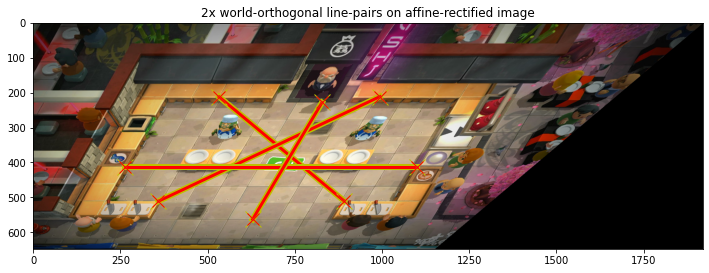

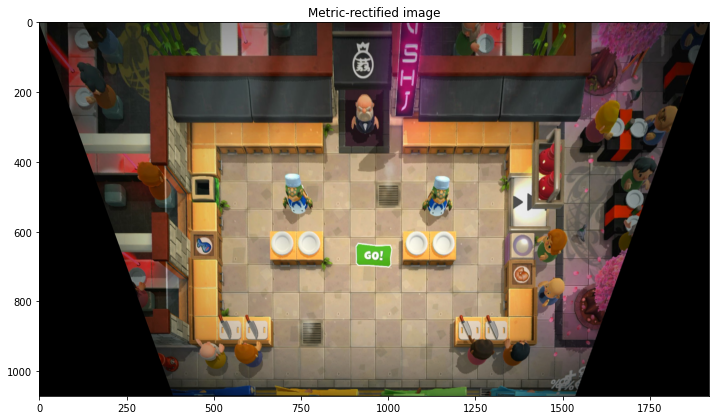

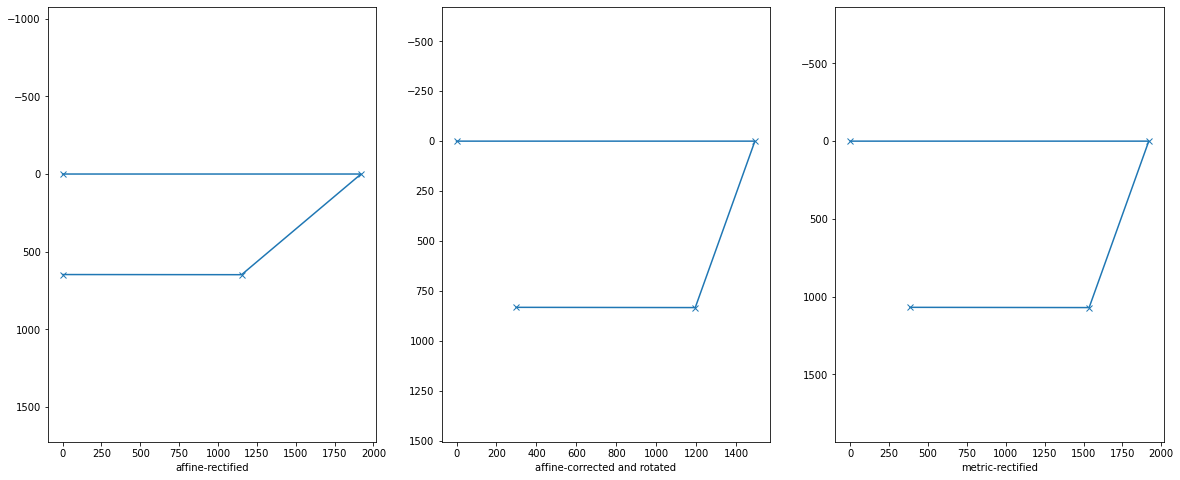

In [5]:
## Example 2.26: Metric rectification I

# 0. Define 2 non-parallel world-orthogonal line-pairs
# Representation: x1, y1, x2, y2
lines_ortho_xy = (
    (533, 212, 891, 510),
    (994, 211, 359, 511),
    (264, 412, 1101, 412),  # world-horizontal line
    (629, 563, 828, 228),
    # (113, 535, 202, 495),
    # (137, 497, 174, 534),
    # (832, 529, 1040, 528),
    # (977, 526, 1068, 399),
)

plt.figure(4, figsize=(12, 8))
plt.imshow(img_affine_rect)
for x1, y1, x2, y2 in lines_ortho_xy:
    xs = (x1, x2)
    ys = (y1, y2)
    plt.plot(xs, ys, "-y", linewidth=6)
    plt.plot(xs, ys, "-r", linewidth=3)
    plt.plot(xs, ys, "xy", markersize=16, linewidth=6)
    plt.plot(xs, ys, "xr", markersize=12, linewidth=3)
plt.title("2x world-orthogonal line-pairs on affine-rectified image")

# 1. Transform into homogeneous coordinates
lines_ortho_homo = np.array(lines_ortho_xy)
x1s, y1s, x2s, y2s = lines_ortho_homo[:, 0], lines_ortho_homo[:, 1], lines_ortho_homo[:, 2], lines_ortho_homo[:, 3]
lines_ortho_homo = np.array((y1s - y2s, x2s - x1s, x1s * y2s - x2s * y1s))  # 3x4
lines_ortho_homo = lines_ortho_homo / np.expand_dims(lines_ortho_homo[2, :], axis=0)

# np.set_printoptions(formatter={'float': lambda x: "{0:0.4f}".format(x)})
# print(f"2x world-orthogonal line-pairs in homogeneous coords (column vectors):\n{lines_ortho_homo}")
# np.set_printoptions(formatter=None)

# 2. Solve for S (2x2 matrix) via null-space / SVD
la, ma, lb, mb = lines_ortho_homo[:2, 0], lines_ortho_homo[:2, 1], lines_ortho_homo[:2, 2], lines_ortho_homo[:2, 3]
LM = np.array((  # LM * (s11, s12, s22)^T = 0
    (la[0]*ma[0], la[0]*ma[1] + la[1]*ma[0], la[1]*ma[1]),
    (lb[0]*mb[0], lb[0]*mb[1] + lb[1]*mb[0], lb[1]*mb[1]),
))
Svec = scipy.linalg.null_space(LM).flatten()
S = np.array((
    (Svec[0], Svec[1]),
    (Svec[1], Svec[2]),
))

# print(f"S = \n{S}")

# 2. Sanity check: S should satisfy orthogonality constraint for world-orthogonal line-pairs
assert(np.abs(la @ S @ ma) <= 1e-10), "S does not satisfy first line-pair's orthogonality constraint"
assert(np.abs(lb @ S @ mb) <= 1e-10), "S does not satisfy second line-pair's orthogonality constraint"

# 3. Solve for affine K s.t. S = K^-1 @ K^-T
# NOTE: book is wrong; if H_A is meant to transform la/ma/lb/mb into la'/ma'/lb'/mb' such that
#       la' @ eye(2) @ mb' == 0, then la @ S @ ma^T == 0 == (K^-T @ la^T)^T @ eye(2) @ (K^-T @ ma^T),
#       i.e. S == K^-1 @ K^-T
K = scipy.linalg.cholesky(S, lower=True)
K = np.linalg.inv(K)
K /= np.sqrt(np.linalg.det(K))  # in eqn 2.16, K within H_A is specified to have det(K) == 1
H_A = np.eye(3)
H_A[:2, :2] = K

print(f"H_A = \n{H_A}")

# 3. Sanity check: K should satisfy orthogonality constraint for world-orthogonal line-pairs
assert(np.abs((la @ np.linalg.inv(K)) @ (np.linalg.inv(K).transpose() @ ma)) <= 1e-10), "K does not satisfy first line-pair's orthogonality constraint"
assert(np.abs((lb @ np.linalg.inv(K)) @ (np.linalg.inv(K).transpose() @ mb)) <= 1e-10), "K does not satisfy second line-pair's orthogonality constraint"

# Define (arbitrary) similarity matrix H_S such that desired content is in final canvas
# We do this in 2 steps:
# 4. figure out rotation such that world-vertical line should be image-vertical
# 5. determine scaling and translation based on the final canvas' dimensions

# 4. Given a world-vertical line, apply H_A to it and measure it's orientation, then choose rotation that undo it
wvline_homo = lines_ortho_homo[:, 3]  # wvline: world-vertical line
wvline_trans_homo = np.linalg.inv(H_A).transpose() @ wvline_homo
rot_trans = np.arctan2(1/wvline_trans_homo[0], -1/wvline_trans_homo[1])  # convention: 0'=up (-y), 90'=right (+x)
rotation_simi_rad = rot_trans
H_rot = np.array((
    (np.cos(rotation_simi_rad), -np.sin(rotation_simi_rad), 0),
    (np.sin(rotation_simi_rad), np.cos(rotation_simi_rad), 0),
    (0, 0, 1),
))

# 5. Choose scaling and translation to ensure that corners of the source image will be within the final canvas
pts_affine_rect_homo = H_affine_rect @ pts_homo
pts_affine_rect_homo = pts_affine_rect_homo / np.expand_dims(pts_affine_rect_homo[2, :], axis=0)
pts_trans_homo = H_rot @ H_A @ pts_affine_rect_homo
pts_trans_homo = pts_trans_homo / np.expand_dims(pts_trans_homo[2, :], axis=0)

xs_trans = pts_trans_homo[0, :]
ys_trans = pts_trans_homo[1, :]
x_min_trans = np.min(xs_trans)
x_max_trans = np.max(xs_trans)
y_min_trans = np.min(ys_trans)
y_max_trans = np.max(ys_trans)
width_trans = x_max_trans - x_min_trans
height_trans = y_max_trans - y_min_trans

width_final = img_affine_rect.shape[1]  # arbitrary
scale_simi = width_final / width_trans
height_final = int(np.ceil(height_trans * scale_simi))
H_scale_trans = np.array((
    (scale_simi, 0, -x_min_trans),
    (0, scale_simi, -y_min_trans),
    (0, 0, 1)
))

H_S = H_scale_trans @ H_rot
H_metric_rect = H_S @ H_A
H_metric_rect /= H_metric_rect[2, 2]

# 5. Sanity check: H should transform pts_sheared_homo into bounding box (width_final, height_final)
pts_metric_rect_homo = H_metric_rect @ pts_affine_rect_homo
pts_metric_rect_homo = pts_metric_rect_homo / np.expand_dims(pts_metric_rect_homo[2, :], axis=0)
pts_metric_rect_xy = np.floor(pts_metric_rect_homo[:2, :]).astype(int)
fudge_px = 1
assert(0-fudge_px <= np.min(pts_metric_rect_xy[0, :]) <= np.max(pts_metric_rect_xy[0, :]) <= width_final+fudge_px), "pts_metric_rect not within width bounds"
assert(0-fudge_px <= np.min(pts_metric_rect_xy[1, :]) <= np.max(pts_metric_rect_xy[1, :]) <= height_final+fudge_px), "pts_metric_rect not within height bounds"

# 6. Warp source image into final canvas
img_metric_rect = cv2.warpPerspective(img_affine_rect, H_metric_rect, dsize=(width_final, height_final))

plt.figure(5, figsize=(12, 8))
plt.imshow(img_metric_rect)
plt.title("Metric-rectified image")

# 7. visualize how the source and transformed points look like
plt.figure(6, figsize=(20, 8))

plt.subplot(1, 3, 1)
plt.plot(pts_affine_rect_homo[0, :], pts_affine_rect_homo[1, :], "x-")
plt.axis("equal")
plt.gca().invert_yaxis()
plt.xlabel("affine-rectified")

plt.subplot(1, 3, 2)
plt.plot(pts_trans_homo[0, :], pts_trans_homo[1, :], "x-")
plt.axis("equal")
plt.gca().invert_yaxis()
plt.xlabel("affine-corrected and rotated")

plt.subplot(1, 3, 3)
plt.plot(pts_metric_rect_homo[0, :], pts_metric_rect_homo[1, :], "x-")
plt.axis("equal")
plt.gca().invert_yaxis()
plt.xlabel("metric-rectified")

print(f"pts = {pts_homo[:2, :].astype(int)}")
print(f"pts_trans_homo = {pts_trans_homo[:2, :].astype(int)}")
print(f"pts_metric_rect = {pts_metric_rect_homo[:2, :].astype(int)}")